In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as kl
import tensorflow.keras.backend as K
import tensorflow.distributions as tfd
import numpy as np

In [2]:
import matplotlib.pyplot as pl

In [3]:
tf.enable_eager_execution()

## Model
We observe two time-series $X_t$, $Y_t$ we want to use RNNs to model the dependence
$$Y_t = f(X_t, \ldots X_0) + \varepsilon_t$$ where $\varepsilon_t$ are IID Gaussian with zero mean. As usual in ML we don't care about the variance of $\varepsilon$.

### True model
the true dependence is
$$Y_t = f_{true}(X_t, \ldots X_0) + \varepsilon_t$$ where $\varepsilon_t \sim Norm(0, \sigma)$ are IID .

The $X_t$ are themselves drawn as IID $X_t\sim Norm(0, 1)$.

### Generate data

In [4]:
time_len = 10
dataset_size = 100
sigma = 0.1

In [5]:
def f_true(X):
    return tf.cumsum(X, axis = -1)

In [6]:
def f_true(X):
    batch_ndim = len(X.shape) - 1
    X_shift = tf.pad(X[..., 1:], [[0,0]] * batch_ndim + [[1, 0]])
    return X + X_shift

In [7]:
X_obs = tfd.Normal(0., 1.).sample([dataset_size, time_len])
ɛ_obs = tfd.Normal(0., sigma).sample([dataset_size, time_len])
Y_obs = f_true(X_obs) + ɛ_obs

In [8]:
print(X_obs.shape, Y_obs.shape)

(100, 10) (100, 10)


### Inference model

In [9]:
def get_model(batch_size=None, stateful=False):
    if stateful:
        assert batch_size is not None, "In stateful RNN, `batch_size` must be known."
    inp = kl.Input([None], batch_size=batch_size)
    x = inp
    x = kl.Reshape([-1, 1])(x)
    x = kl.LSTM(5, return_sequences=True, stateful=stateful)(x)
    x = kl.TimeDistributed(kl.Dense(1))(x)
    x = kl.Reshape([-1])(x)
    return keras.Model(inp, x)

In [10]:
model = get_model()#time_len=int(X_obs.shape[1]))
model.predict(X_obs).shape

(100, 10)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
reshape (Reshape)            (None, None, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 5)           140       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           6         
_________________________________________________________________
reshape_1 (Reshape)          (None, None)              0         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


### Training

In [12]:
model.compile(
    optimizer=tf.train.AdamOptimizer(), 
    loss = "mean_squared_error"
)

In [13]:
model.fit(
    X_obs.numpy(), Y_obs.numpy(), 
    epochs=1000, validation_split=0.3, batch_size=100)

Train on 70 samples, validate on 30 samples
Epoch 1/1000
70/70 [==============================] - 0s 1ms/step - loss: 4.3694 - val_loss: 3.9701
Epoch 2/1000
70/70 [==============================] - 0s 953us/step - loss: 4.3627 - val_loss: 3.9649
Epoch 3/1000
70/70 [==============================] - 0s 981us/step - loss: 4.3560 - val_loss: 3.9596
Epoch 4/1000
70/70 [==============================] - 0s 909us/step - loss: 4.3493 - val_loss: 3.9543
Epoch 5/1000
70/70 [==============================] - 0s 932us/step - loss: 4.3426 - val_loss: 3.9491
Epoch 6/1000
70/70 [==============================] - 0s 931us/step - loss: 4.3360 - val_loss: 3.9439
Epoch 7/1000
70/70 [==============================] - 0s 945us/step - loss: 4.3294 - val_loss: 3.9387
Epoch 8/1000
70/70 [==============================] - 0s 939us/step - loss: 4.3229 - val_loss: 3.9335
Epoch 9/1000
70/70 [==============================] - 0s 910us/step - loss: 4.3164 - val_loss: 3.9283
Epoch 10/1000
70/70 [===================

Epoch 81/1000
70/70 [==============================] - 0s 989us/step - loss: 3.8271 - val_loss: 3.5120
Epoch 82/1000
70/70 [==============================] - 0s 939us/step - loss: 3.8191 - val_loss: 3.5049
Epoch 83/1000
70/70 [==============================] - 0s 945us/step - loss: 3.8110 - val_loss: 3.4979
Epoch 84/1000
70/70 [==============================] - 0s 960us/step - loss: 3.8029 - val_loss: 3.4907
Epoch 85/1000
70/70 [==============================] - 0s 946us/step - loss: 3.7947 - val_loss: 3.4836
Epoch 86/1000
70/70 [==============================] - 0s 924us/step - loss: 3.7865 - val_loss: 3.4764
Epoch 87/1000
70/70 [==============================] - 0s 945us/step - loss: 3.7782 - val_loss: 3.4691
Epoch 88/1000
70/70 [==============================] - 0s 932us/step - loss: 3.7699 - val_loss: 3.4618
Epoch 89/1000
70/70 [==============================] - 0s 924us/step - loss: 3.7615 - val_loss: 3.4545
Epoch 90/1000
70/70 [==============================] - 0s 924us/step - lo

70/70 [==============================] - 0s 961us/step - loss: 3.0922 - val_loss: 2.8679
Epoch 161/1000
70/70 [==============================] - 0s 931us/step - loss: 3.0824 - val_loss: 2.8593
Epoch 162/1000
70/70 [==============================] - 0s 931us/step - loss: 3.0726 - val_loss: 2.8507
Epoch 163/1000
70/70 [==============================] - 0s 910us/step - loss: 3.0629 - val_loss: 2.8421
Epoch 164/1000
70/70 [==============================] - 0s 910us/step - loss: 3.0531 - val_loss: 2.8334
Epoch 165/1000
70/70 [==============================] - 0s 917us/step - loss: 3.0434 - val_loss: 2.8248
Epoch 166/1000
70/70 [==============================] - 0s 910us/step - loss: 3.0336 - val_loss: 2.8162
Epoch 167/1000
70/70 [==============================] - 0s 917us/step - loss: 3.0239 - val_loss: 2.8076
Epoch 168/1000
70/70 [==============================] - 0s 938us/step - loss: 3.0142 - val_loss: 2.7990
Epoch 169/1000
70/70 [==============================] - 0s 924us/step - loss: 3

Epoch 239/1000
70/70 [==============================] - 0s 931us/step - loss: 2.3561 - val_loss: 2.2094
Epoch 240/1000
70/70 [==============================] - 0s 910us/step - loss: 2.3471 - val_loss: 2.2014
Epoch 241/1000
70/70 [==============================] - 0s 932us/step - loss: 2.3382 - val_loss: 2.1934
Epoch 242/1000
70/70 [==============================] - 0s 931us/step - loss: 2.3292 - val_loss: 2.1854
Epoch 243/1000
70/70 [==============================] - 0s 917us/step - loss: 2.3202 - val_loss: 2.1774
Epoch 244/1000
70/70 [==============================] - 0s 923us/step - loss: 2.3112 - val_loss: 2.1694
Epoch 245/1000
70/70 [==============================] - 0s 896us/step - loss: 2.3023 - val_loss: 2.1614
Epoch 246/1000
70/70 [==============================] - 0s 1ms/step - loss: 2.2933 - val_loss: 2.1534
Epoch 247/1000
70/70 [==============================] - 0s 910us/step - loss: 2.2844 - val_loss: 2.1454
Epoch 248/1000
70/70 [==============================] - 0s 924us/s

Epoch 318/1000
70/70 [==============================] - 0s 1ms/step - loss: 1.6672 - val_loss: 1.5942
Epoch 319/1000
70/70 [==============================] - 0s 939us/step - loss: 1.6589 - val_loss: 1.5868
Epoch 320/1000
70/70 [==============================] - 0s 917us/step - loss: 1.6507 - val_loss: 1.5794
Epoch 321/1000
70/70 [==============================] - 0s 910us/step - loss: 1.6425 - val_loss: 1.5720
Epoch 322/1000
70/70 [==============================] - 0s 903us/step - loss: 1.6343 - val_loss: 1.5647
Epoch 323/1000
70/70 [==============================] - 0s 903us/step - loss: 1.6262 - val_loss: 1.5573
Epoch 324/1000
70/70 [==============================] - 0s 917us/step - loss: 1.6180 - val_loss: 1.5499
Epoch 325/1000
70/70 [==============================] - 0s 953us/step - loss: 1.6099 - val_loss: 1.5426
Epoch 326/1000
70/70 [==============================] - 0s 1ms/step - loss: 1.6018 - val_loss: 1.5353
Epoch 327/1000
70/70 [==============================] - 0s 917us/ste

Epoch 397/1000
70/70 [==============================] - 0s 924us/step - loss: 1.0910 - val_loss: 1.0701
Epoch 398/1000
70/70 [==============================] - 0s 946us/step - loss: 1.0850 - val_loss: 1.0645
Epoch 399/1000
70/70 [==============================] - 0s 974us/step - loss: 1.0790 - val_loss: 1.0589
Epoch 400/1000
70/70 [==============================] - 0s 928us/step - loss: 1.0730 - val_loss: 1.0534
Epoch 401/1000
70/70 [==============================] - 0s 946us/step - loss: 1.0670 - val_loss: 1.0479
Epoch 402/1000
70/70 [==============================] - 0s 1ms/step - loss: 1.0611 - val_loss: 1.0425
Epoch 403/1000
70/70 [==============================] - 0s 917us/step - loss: 1.0552 - val_loss: 1.0370
Epoch 404/1000
70/70 [==============================] - 0s 924us/step - loss: 1.0493 - val_loss: 1.0316
Epoch 405/1000
70/70 [==============================] - 0s 902us/step - loss: 1.0435 - val_loss: 1.0262
Epoch 406/1000
70/70 [==============================] - 0s 902us/s

Epoch 476/1000
70/70 [==============================] - 0s 939us/step - loss: 0.7068 - val_loss: 0.7141
Epoch 477/1000
70/70 [==============================] - 0s 938us/step - loss: 0.7031 - val_loss: 0.7106
Epoch 478/1000
70/70 [==============================] - 0s 932us/step - loss: 0.6994 - val_loss: 0.7071
Epoch 479/1000
70/70 [==============================] - 0s 931us/step - loss: 0.6957 - val_loss: 0.7036
Epoch 480/1000
70/70 [==============================] - 0s 924us/step - loss: 0.6920 - val_loss: 0.7002
Epoch 481/1000
70/70 [==============================] - 0s 932us/step - loss: 0.6884 - val_loss: 0.6968
Epoch 482/1000
70/70 [==============================] - 0s 924us/step - loss: 0.6847 - val_loss: 0.6934
Epoch 483/1000
70/70 [==============================] - 0s 1ms/step - loss: 0.6811 - val_loss: 0.6901
Epoch 484/1000
70/70 [==============================] - 0s 917us/step - loss: 0.6775 - val_loss: 0.6868
Epoch 485/1000
70/70 [==============================] - 0s 946us/s

Epoch 555/1000
70/70 [==============================] - 0s 910us/step - loss: 0.4739 - val_loss: 0.4986
Epoch 556/1000
70/70 [==============================] - 0s 902us/step - loss: 0.4717 - val_loss: 0.4965
Epoch 557/1000
70/70 [==============================] - 0s 903us/step - loss: 0.4694 - val_loss: 0.4945
Epoch 558/1000
70/70 [==============================] - 0s 896us/step - loss: 0.4672 - val_loss: 0.4925
Epoch 559/1000
70/70 [==============================] - 0s 910us/step - loss: 0.4650 - val_loss: 0.4904
Epoch 560/1000
70/70 [==============================] - 0s 917us/step - loss: 0.4628 - val_loss: 0.4884
Epoch 561/1000
70/70 [==============================] - 0s 917us/step - loss: 0.4606 - val_loss: 0.4865
Epoch 562/1000
70/70 [==============================] - 0s 917us/step - loss: 0.4585 - val_loss: 0.4845
Epoch 563/1000
70/70 [==============================] - 0s 923us/step - loss: 0.4563 - val_loss: 0.4826
Epoch 564/1000
70/70 [==============================] - 0s 924us

Epoch 634/1000
70/70 [==============================] - 0s 929us/step - loss: 0.3332 - val_loss: 0.3720
Epoch 635/1000
70/70 [==============================] - 0s 910us/step - loss: 0.3318 - val_loss: 0.3707
Epoch 636/1000
70/70 [==============================] - 0s 924us/step - loss: 0.3305 - val_loss: 0.3695
Epoch 637/1000
70/70 [==============================] - 0s 931us/step - loss: 0.3291 - val_loss: 0.3683
Epoch 638/1000
70/70 [==============================] - 0s 924us/step - loss: 0.3278 - val_loss: 0.3670
Epoch 639/1000
70/70 [==============================] - 0s 909us/step - loss: 0.3264 - val_loss: 0.3658
Epoch 640/1000
70/70 [==============================] - 0s 939us/step - loss: 0.3251 - val_loss: 0.3646
Epoch 641/1000
70/70 [==============================] - 0s 924us/step - loss: 0.3238 - val_loss: 0.3634
Epoch 642/1000
70/70 [==============================] - 0s 982us/step - loss: 0.3225 - val_loss: 0.3622
Epoch 643/1000
70/70 [==============================] - 0s 924us

Epoch 713/1000
70/70 [==============================] - 0s 910us/step - loss: 0.2472 - val_loss: 0.2927
Epoch 714/1000
70/70 [==============================] - 0s 938us/step - loss: 0.2464 - val_loss: 0.2919
Epoch 715/1000
70/70 [==============================] - 0s 939us/step - loss: 0.2456 - val_loss: 0.2911
Epoch 716/1000
70/70 [==============================] - 0s 960us/step - loss: 0.2447 - val_loss: 0.2903
Epoch 717/1000
70/70 [==============================] - 0s 924us/step - loss: 0.2439 - val_loss: 0.2895
Epoch 718/1000
70/70 [==============================] - 0s 924us/step - loss: 0.2431 - val_loss: 0.2887
Epoch 719/1000
70/70 [==============================] - 0s 924us/step - loss: 0.2422 - val_loss: 0.2879
Epoch 720/1000
70/70 [==============================] - 0s 924us/step - loss: 0.2414 - val_loss: 0.2871
Epoch 721/1000
70/70 [==============================] - 0s 910us/step - loss: 0.2406 - val_loss: 0.2863
Epoch 722/1000
70/70 [==============================] - 0s 895us

Epoch 792/1000
70/70 [==============================] - 0s 932us/step - loss: 0.1930 - val_loss: 0.2399
Epoch 793/1000
70/70 [==============================] - 0s 931us/step - loss: 0.1924 - val_loss: 0.2394
Epoch 794/1000
70/70 [==============================] - 0s 924us/step - loss: 0.1919 - val_loss: 0.2388
Epoch 795/1000
70/70 [==============================] - 0s 917us/step - loss: 0.1913 - val_loss: 0.2383
Epoch 796/1000
70/70 [==============================] - 0s 903us/step - loss: 0.1908 - val_loss: 0.2378
Epoch 797/1000
70/70 [==============================] - 0s 902us/step - loss: 0.1903 - val_loss: 0.2372
Epoch 798/1000
70/70 [==============================] - 0s 895us/step - loss: 0.1897 - val_loss: 0.2367
Epoch 799/1000
70/70 [==============================] - 0s 910us/step - loss: 0.1892 - val_loss: 0.2362
Epoch 800/1000
70/70 [==============================] - 0s 923us/step - loss: 0.1887 - val_loss: 0.2356
Epoch 801/1000
70/70 [==============================] - 0s 917us

Epoch 871/1000
70/70 [==============================] - 0s 910us/step - loss: 0.1575 - val_loss: 0.2040
Epoch 872/1000
70/70 [==============================] - 0s 903us/step - loss: 0.1571 - val_loss: 0.2037
Epoch 873/1000
70/70 [==============================] - 0s 903us/step - loss: 0.1568 - val_loss: 0.2033
Epoch 874/1000
70/70 [==============================] - 0s 981us/step - loss: 0.1564 - val_loss: 0.2029
Epoch 875/1000
70/70 [==============================] - 0s 960us/step - loss: 0.1560 - val_loss: 0.2025
Epoch 876/1000
70/70 [==============================] - 0s 953us/step - loss: 0.1557 - val_loss: 0.2022
Epoch 877/1000
70/70 [==============================] - 0s 931us/step - loss: 0.1553 - val_loss: 0.2018
Epoch 878/1000
70/70 [==============================] - 0s 931us/step - loss: 0.1550 - val_loss: 0.2014
Epoch 879/1000
70/70 [==============================] - 0s 924us/step - loss: 0.1546 - val_loss: 0.2011
Epoch 880/1000
70/70 [==============================] - 0s 924us

Epoch 950/1000
70/70 [==============================] - 0s 925us/step - loss: 0.1336 - val_loss: 0.1787
Epoch 951/1000
70/70 [==============================] - 0s 924us/step - loss: 0.1334 - val_loss: 0.1785
Epoch 952/1000
70/70 [==============================] - 0s 946us/step - loss: 0.1331 - val_loss: 0.1782
Epoch 953/1000
70/70 [==============================] - 0s 1ms/step - loss: 0.1329 - val_loss: 0.1779
Epoch 954/1000
70/70 [==============================] - 0s 967us/step - loss: 0.1326 - val_loss: 0.1777
Epoch 955/1000
70/70 [==============================] - 0s 960us/step - loss: 0.1324 - val_loss: 0.1774
Epoch 956/1000
70/70 [==============================] - 0s 953us/step - loss: 0.1321 - val_loss: 0.1772
Epoch 957/1000
70/70 [==============================] - 0s 974us/step - loss: 0.1319 - val_loss: 0.1769
Epoch 958/1000
70/70 [==============================] - 0s 953us/step - loss: 0.1317 - val_loss: 0.1766
Epoch 959/1000
70/70 [==============================] - 0s 974us/s

### Plot predictions vs truth

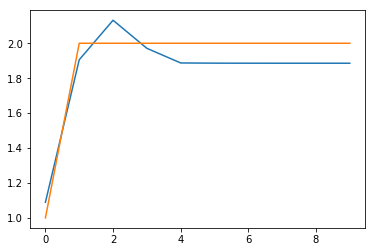

In [14]:
X = np.ones(10)#tfd.Normal(0., 1.).sample(100)
Y_true = f_true(X)
Y_pred = model.predict(X[None, :]).flatten()

pl.plot(Y_pred)
pl.plot(Y_true.numpy())

### Model for serving
Create a model that can take the inputs consecutively and remembers its inner state.

In [15]:
model_serv = get_model(batch_size=1, stateful=True)
model_serv.set_weights(model.get_weights())

In [16]:
model_serv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1, None)                 0         
_________________________________________________________________
reshape_2 (Reshape)          (1, None, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 5)              140       
_________________________________________________________________
time_distributed_1 (TimeDist (1, None, 1)              6         
_________________________________________________________________
reshape_3 (Reshape)          (1, None)                 0         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_serv.reset_states()
for i in range(4):
    print(model_serv.predict([[1]]))

[[1.0897558]]
[[1.9054682]]
[[2.1317358]]
[[1.9710338]]


In [20]:
model_serv.reset_states()
for i in range(2):
    print(model_serv(K.ones([1,2], K.floatx())))

tf.Tensor([[1.0897558 1.9054682]], shape=(1, 2), dtype=float32)
tf.Tensor([[2.1317358 1.9710338]], shape=(1, 2), dtype=float32)


In [21]:
model.predict(np.array([[1, 1, 1, 1]]))

array([[1.0897558, 1.9054682, 2.1317358, 1.9710338]], dtype=float32)

In [23]:
model_serv(K.ones([1,4], K.floatx()))

<tf.Tensor: id=4702514, shape=(1, 4), dtype=float32, numpy=array([[1.8871744, 1.8860266, 1.8857841, 1.8856192]], dtype=float32)>

In [19]:
## This however does not work (I don't know why.)
model_serv.reset_states()
for i in range(2):
    print(model_serv.predict([[1, 1]]))

ValueError: Tensor's shape (2, 5) is not compatible with supplied shape (1, 5)